# Zoov coding task
## Francesco Cusimano

### Set up

In [1]:
import pandas as pd
import numpy as np
#pip install jours-feries-france
from jours_feries_france import JoursFeries


### Preliminary data
__Description:__
- National holidays extracted with jours_feries_france package.
- Cities selected: Toulon, Grenoble, Perpignan, Mulhouse, Saint-Nazaire.
- Population data from Wikipedia, year 2017.
- Bike frendliness score obtained from the _[Baromètre des villes cyclables 2019](https://www.fub.fr/sites/fub/files/fub/Communiques/dossier_de_presse_barometre_bd_11-02-2020.pdf)_. Score used to determine initial number of daily trips.

In [2]:
dates = pd.date_range("01/01/2020", "31/12/2020")
holidays = JoursFeries.for_year(2020)

cities = ["Toulon", "Grenoble", "Perpignan", "Mulhouse", "Saint-Nazaire"]
populations = [163760, 158454, 120158, 109443, 69993]  # 2017 wikipedia
bikes_per_cities = [round((1000 / sum(populations)) * i) for i in populations]
bike_friendliness = ["F", "B", "F", "E", "D"]
bike_score_dict = {"B": 5, "D": 4, "E": 3, "F": 2}

initial_info = zip(cities, populations, bikes_per_cities, bike_friendliness)

print(
    "Cities:",
    cities,
    "\nPopulation:",
    populations,
    "\nBike friendliness:",
    bike_friendliness,
    "\nBikes per city:",
    bikes_per_cities,
    "\nTotal Bikes:",
    sum(bikes_per_cities),
    sep="\n",
)


Cities:
['Toulon', 'Grenoble', 'Perpignan', 'Mulhouse', 'Saint-Nazaire']

Population:
[163760, 158454, 120158, 109443, 69993]

Bike friendliness:
['F', 'B', 'F', 'E', 'D']

Bikes per city:
[263, 255, 193, 176, 113]

Total Bikes:
1000


### Data generation

__Description:__

##### Trips (starting point)
1. Generating daily trips baseline for each city by multiplying its number of bikes by its bike "friendliness" score.
2. Increasing daily trips based on season (+0% for Winter, +30% for Spring, +50% for Summer, +20% for Autumn)
3. Increasing daily trips during weekends by 30%.
4. Increasing daily trips during national holidays by 20%.
5. Decrease daily trips by 85% during first covid lockdown (from March 17 to May 13).
6. Adding noise and linear growth trend.

##### Users
- `users`: Number of daily users. Obtained with daily trips divided by number between 1.1 and 6 centered around 3. Assumption that on average, the users will perform around 3 trips per day .
- `subscribers`: Number of daily subcriber users. Obtained by generating `subscriber_ratio`, which gives the percentage of subscriber users out of all users. This ratio is around 75% during weekdays, and around 60% during weekends, based on the assumption that subscribers are more likely to use the bikes for communiting.
- `occasional_users`: Number of daily non subscriber users. Total subscribers minus subscribers.
- `new_subscribers`: Daily growth in subscribers equal to 1% of daily occasional users, assumption that unsubscriptions are accounted for.
- `total_subscribers`: Running total of new subscribers. Initial number set at triple of first day's user count.

##### Bikes
- `bikes_in_maintenance`: Number of bikes in maintenance for the day, equal to number of trips per bike.
- `bikes_available`: Number of available bike for the day, equal to total bikes allocated to city minus bikes in maintenance.
- `bike_maintenance_cost`: Daily total bike maintenance cost (in €), obtained by multiplying number of bikes in maintenance with a random number between 30 and 100. Assumption that most repair costs per bike will fall in that range.

##### Stations
- `stations`: Number of stations per city, obtained by calculating 2.5 docks per bikes and assuming 15 docks per station. Assumption that the number of stations per city stays constant.
- `station_maintenance_cost`: Daily station maintenance cost (in €), obtained by generating an array of 0 and 1, where the probability of having a 1 is lower but increases with more stations. This array is multiplyied by a random number between 300 and 1000, with the assumption that station repair costs fall into this range. The idea is that station repairs are not done every day, but only after accidents or vandalism.

##### Trips metrics
- `trips_per_user`: Daily trips per user, obtained by dividing daily trips by number of daily users.
- `trips_per_bike`: Daily trips per bike, obtained by dividing daily trips by number of bikes available.
- `trips_per_1k_residents`: Daily trips per 1,000 residents, based on the city's population.
- `avg_trip_duration`: Average daily trip duration (in min), random number taken from a distribution centered around 15.
- `avg_trip_distance`: Average daily trip distance (in km), based on average speed in km/h obtained from a random distribution between 12 to 16, centered on 14.
- `saved_CO2`: Approximate amount of daily saved CO2 emmission in kg, based on the assumption that each km saves 66g of CO2 (https://www.zoov.eu/en/blog/bike-life/sustainability-report-measuring-our-environmental-impact).

##### Business metrics
- `daily_subcriber_revenue`: Daily revenue from subscribers (in €), based on a yearly subscription fee of 120€. Assumption that subscription allows for unlimited bike use.
- `daily_occasional_users_revenue`: Daily revenue from occasional users (in €), based on a 1€ unlocking fee plus 15 cents per ride minute.
- `daily_revenue`: Combined daily revenue from subscribers and occasional users (in €).
- `daily_operational_expenses`: Daily operational expenses (in €), obtained by adding bike maintenance costs and station maintenance costs.
- `daily_operating_income`: Daily operating income (in €), obtained by substracting daily operational expenses to daily income.

In [3]:
df_dictionary = {}

for city, population, bikes, bike_friendliness_score in initial_info:

    print(f"Generating data for {city}")

    ###### TRIPS ######

    # Baseline
    trips = bike_score_dict[bike_friendliness_score] * bikes

    # Seasons
    trips = np.where((dates.month % 12 + 3) // 3 == 2, trips * 1.3, trips)  # Spring
    trips = np.where((dates.month % 12 + 3) // 3 == 3, trips * 1.5, trips)  # Summer
    trips = np.where((dates.month % 12 + 3) // 3 == 4, trips * 1.2, trips)  # Autumn

    # Weekends
    trips = np.where(dates.dayofweek >= 5, trips * 1.3, trips)

    # Holidays
    trips = np.where(dates.isin(holidays.values()), trips * 1.2, trips)

    # Covid
    trips = np.where(
        (dates.date > pd.to_datetime("2020-03-17"))
        & (dates.date < pd.to_datetime("2020-05-13")),
        trips * 0.15,
        trips,
    )

    # Noise
    noise = np.random.randn(len(dates)) * 60
    trips += noise

    # Growth trend
    upward_trend = np.arange(len(dates)) * 1.5
    trips += upward_trend

    ###### USERS ######

    # Number of daily users
    users = trips / np.clip(
        np.random.normal(loc=3, scale=0.5, size=len(dates)), a_min=1.1, a_max=6.0
    )

    # Number of daily subcriber users
    subscriber_ratio = np.where(
        dates.dayofweek >= 5,
        np.random.normal(loc=0.60, scale=0.01, size=len(dates)),  # weekends
        np.random.normal(loc=0.75, scale=0.01, size=len(dates)),  # weekdays
    )
    subscribers = users * subscriber_ratio

    # Number of daily occasional users
    occasional_users = users - subscribers

    # Number of new subscribers
    new_subscribers = occasional_users * 0.05

    # Number of total subscribers
    total_subscribers = []
    initial_count = users[0] * 3
    for i in range(len(occasional_users)):
        initial_count += new_subscribers[i]
        total_subscribers.append(initial_count)

    ###### BIKES ######

    # Bikes in maintenance
    bikes_in_maintenance = trips / bikes

    # Bikes available
    bikes_available = bikes - bikes_in_maintenance

    # Bike maintenance costs
    bike_maintenance_cost = bikes_in_maintenance * np.random.uniform(30, 100)

    ###### STATIONS ######

    # Number of stations
    stations = (bikes / 15) * 2.5

    # Station maintenance cost (more stations -> more frequent repairs needed)
    p = 1 - (np.array(stations) / 300)
    station_maintenance_cost = np.random.choice(
        [0, 1], size=len(dates), p=[p, 1 - p]
    ) * np.random.uniform(300, 1000, size=len(dates))

    ###### TRIP METRICS ######

    # Trips per user
    trips_per_user = trips / users

    # Trips per bike
    trips_per_bike = trips / bikes_available
    # should be around 4 - 8

    # Trips per 1,000 residents
    trips_per_1k_residents = trips / (population / 1000)

    # Average trip duration (distribution centered around 15 min)
    avg_trip_duration = np.random.normal(loc=15, scale=2, size=len(dates))

    # Average trip distance (based on average speed of 14 km/h)
    avg_trip_distance = (
        avg_trip_duration
        * np.clip(
            np.random.normal(loc=14, scale=0.5, size=len(dates)), a_min=12, a_max=16
        )
        / 60
    )

    # Daily CO2 saved
    saved_CO2 = avg_trip_distance * trips * 0.066

    ###### BUSINESS METRICS ######

    # Daily subcribers revenue
    daily_subcribers_revenue = np.array(total_subscribers) * 0.33

    # Daily occasional users revenue
    total_ride_time = avg_trip_duration * trips
    occasional_users_ride_time = total_ride_time * (1 - subscriber_ratio)
    daily_occasional_users_revenue = (
        occasional_users * 1 + 0.15 * occasional_users_ride_time
    )

    # Daily revenue
    daily_revenue = daily_subcribers_revenue + daily_occasional_users_revenue

    # Daily operational expenses
    daily_operational_expenses = station_maintenance_cost + bike_maintenance_cost

    # Daily operating income
    daily_operating_income = daily_revenue - daily_operational_expenses

    ###### DATAFRAME CREATION ######

    df_dictionary[city] = pd.DataFrame(
        {
            "date": dates,
            "city": city,
            "trips": np.round(trips).astype(int),
            "users": np.round(users).astype(int),
            "subscribers": np.round(subscribers).astype(int),
            "occasional_users": np.round(occasional_users).astype(int),
            "new_subscribers": np.round(new_subscribers).astype(int),
            "total_subscribers": np.array(total_subscribers).astype(int),
            "bikes_available": bikes_available.astype(int),
            "bikes_in_maintenance": bikes_in_maintenance.astype(int),
            "bike_maintenance_cost": bike_maintenance_cost.astype(int),
            "stations": int(stations),
            "station_maintenance_cost": station_maintenance_cost.astype(int),
            "trips_per_user": trips_per_user.astype(int),
            "trips_per_bike": trips_per_bike,
            "trips_per_1k_residents": trips_per_1k_residents,
            "avg_trip_duration": avg_trip_duration,
            "avg_trip_distance": avg_trip_distance,
            "saved_CO2": saved_CO2,
            "daily_subcribers_revenue": daily_subcribers_revenue,
            "daily_occasional_users_revenue": daily_occasional_users_revenue,
            "daily_revenue": daily_revenue,
            "daily_operational_expenses": daily_operational_expenses,
            "daily_operating_income": daily_operating_income,
        }
    )


Generating data for Toulon
Generating data for Grenoble
Generating data for Perpignan
Generating data for Mulhouse
Generating data for Saint-Nazaire


### Exporting

In [8]:
final_df = pd.DataFrame()
for key in df_dictionary.keys():
    final_df = final_df.append(df_dictionary[key])

final_df.to_csv("final_df.csv", index=False)


In [9]:
final_df.head().T

,0,1,2,3,4
date,2020-01-01 00:00:00,2020-01-02 00:00:00,2020-01-03 00:00:00,2020-01-04 00:00:00,2020-01-05 00:00:00
city,Toulon,Toulon,Toulon,Toulon,Toulon
trips,736,476,573,667,666
users,259,122,145,159,183
subscribers,197,92,106,95,110
occasional_users,63,30,39,63,73
new_subscribers,3,1,2,3,4
total_subscribers,781,782,784,787,791
bikes_available,260,261,260,260,260
bikes_in_maintenance,2,1,2,2,2


In [10]:
final_df['subscribers']

0      197
1       92
2      106
3       95
4      110
      ... 
361    227
362    252
363    315
364    248
365    211
Name: subscribers, Length: 1830, dtype: int64

In [11]:
final_df['occasional_users']

0       63
1       30
2       39
3       63
4       73
      ... 
361    160
362     90
363    103
364     80
365     66
Name: occasional_users, Length: 1830, dtype: int64

In [315]:
population

69993

In [301]:
sum(bikes_in_maintenance)

2965.632597220641

In [310]:
max(final_df['trips']/final_df['bikes_available'])

15.122171945701357

array([  0.        , 483.85417986, 313.2221413 ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        , 791.50653555,   0.        ,
         0.        , 987.18007887, 533.60329587, 954.27822213,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        , 448.81054423,   0.        ,
       611.44108984,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        , 471.14199177,
       582.06431369, 589.36636673,   0.        ,   0.        ,
       924.93413338,   0.        ,   0.        , 928.36992345,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        , 971.11296163,   0.        , 607.04359813,
         0.        ,   0.        , 529.99886668, 521.40311563,
         0.        ,   0.        , 483.49333218, 495.49404712,
         0.        , 777.6979907 ,   0.        ,   0.        ,
         0.        ,   0.        , 375.13613953,   0.  

array([  0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        , 591.13166168,
       701.78530699,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.  

In [18]:
import matplotlib.pyplot as plt

def plot_time_series(time, values, label):
    plt.figure(figsize=(10,6))
    plt.plot(time, values)
    plt.xlabel("Time", fontsize=20)
    plt.ylabel("Value", fontsize=20)
    plt.title(label, fontsize=20)
    plt.grid(True)

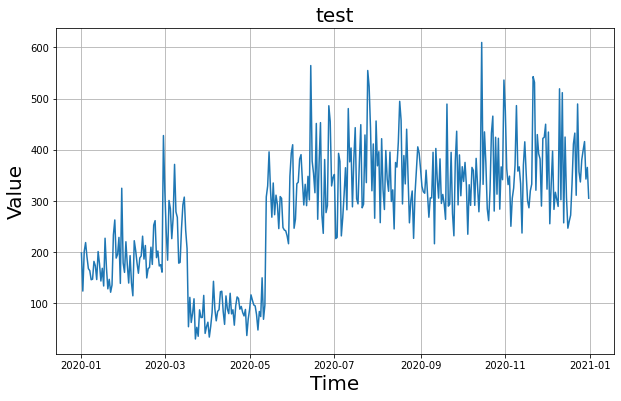

In [27]:
plot_time_series(dates, df_dictionary['Saint-Nazaire']['users'],'test')